## Data Preprocess

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9'
from deepsramp import *

### Proprocess GTF and FASTA

In [2]:
%%time
gtf = read_gtf('data/Homo_sapiens.GRCh38.79.gtf.gz')
seqs = read_seq('data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51662809it [02:30, 343722.38it/s]

CPU times: user 1min 43s, sys: 1min 31s, total: 3min 14s
Wall time: 3min 13s


In [3]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 16.6 s, sys: 1.29 s, total: 17.9 s
Wall time: 17.9 s


In [4]:
%%time
gtfm = read_gtf('data/Mus_musculus.GRCm39.109.gtf.gz')
seqsm = read_seq('data/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
45470460it [01:51, 408561.56it/s]

CPU times: user 1min 21s, sys: 38.8 s, total: 2min
Wall time: 2min 17s


In [5]:
%%time
sdfm = get_mature_splice(gtfm, seqsm, grp=['id', 'trans'], keepmax=False)
ndfm = get_mature_cds(gtfm, sdfm, grp=['id', 'trans'])

CPU times: user 11.8 s, sys: 535 ms, total: 12.4 s
Wall time: 12.4 s


#### Full Trans Mode

In [10]:
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_full_splice(gtf, sdf, seqs, grp=['id', 'trans'])
ndf = get_full_cds(gtf, ndf, grp=['id', 'trans'])

In [11]:
sdfm = get_mature_splice(gtfm, seqsm, grp=['id', 'trans'], keepmax=False)
ndfm = get_full_splice(gtfm, sdfm, seqsm, grp=['id', 'trans'])
ndfm = get_full_cds(gtfm, ndfm, grp=['id', 'trans'])

### Preprocess of SRAMP1 data

In [14]:
def get_sramp_dataset_all(file, rndf, downsample=False, mode='mature'):
    train = pd.read_csv(file)
    train['Class'] = (train['Class'] + 1) // 2
    train['Position'] -= 1
    keep = []
    for _, trans, pos, claz in tqdm(train.itertuples(), total=train.shape[0]):
        if trans not in rndf.index: 
            keep += [0]
        elif DRACH_PAT.findall(rndf.loc[trans].seq[pos-2:pos+3]):
            keep += [1]
        else:
            keep += [0]

    train['keep'] = keep

    train = train[train.keep == 1]
    if downsample:
        pos = train[train.Class == 1]
        neg = train[train.Class == 0].sample(pos.shape[0])
        train = pd.concat([pos, neg], axis=0)

    lookupdf = rndf.reset_index().set_index('id')
    res = []
    for idx, trans, pos, claz, _ in tqdm(train.itertuples(), total=train.shape[0]):
        tdf = rndf.loc[trans]
        genome_pos = get_genome_pos(pos, tdf, mode=mode)
        tdf = lookupdf.loc[[tdf.id]].copy()
        tres = []
        for _, ttdf in tdf.iterrows() :
            if mode == 'mature':
                trans_pos = get_mature_pos(genome_pos, ttdf)
            else:
                trans_pos = get_full_pos(genome_pos, ttdf)
            tres += [trans_pos]
        tdf['pos'] = tres
        tdf = tdf[tdf.pos != -1]
        tdf['label'] = claz
        tdf['grp'] = tdf[0] + tdf[6] + str(genome_pos)
        # tdf['grp'] = file + str(idx)
        res += [tdf.dropna()]
    res = pd.concat(res, axis=0)

    return res

In [7]:
rndf = ndf.reset_index().set_index('trans')
traindf = get_sramp_dataset_all('data/sramp1/mature_train.csv', rndf, downsample=True)
testdf = get_sramp_dataset_all('data/sramp1/mature_test.csv', rndf)

100%|██████████| 73551/73551 [02:57<00:00, 414.70it/s]


In [8]:
rndfm = ndfm.reset_index().set_index('trans')
traindfm = get_sramp_dataset_all('data/sramp1/mature_train.csv', rndfm, downsample=True)
testdfm = get_sramp_dataset_all('data/sramp1/mature_test.csv', rndfm)

100%|██████████| 45690/45690 [01:45<00:00, 432.76it/s]


In [9]:
utils.save([traindf, testdf], 'data/sramp1/sramp1_mature.data')

In [15]:
rndf = ndf.reset_index().set_index('trans')
traindf = get_sramp_dataset_all('data/sramp1/full_train.csv', rndf, downsample=True, mode='full')
testdf = get_sramp_dataset_all('data/sramp1/full_test.csv', rndf, mode='full')

100%|██████████| 83343/83343 [03:19<00:00, 417.01it/s]


In [16]:
rndfm = ndfm.reset_index().set_index('trans')
traindfm = get_sramp_dataset_all('data/sramp1/full_train.csv', rndfm, downsample=True, mode='full')
testdfm = get_sramp_dataset_all('data/sramp1/full_test.csv', rndfm, mode='full')

100%|██████████| 49395/49395 [01:53<00:00, 434.70it/s]


In [17]:
utils.save([traindf, testdf], 'data/sramp1/sramp1_full.data')

## Train

In [3]:
traindf, testdf = utils.load('data/sramp1/sramp1_mature.data')

In [ ]:
traindf, testdf = utils.load('data/sramp1/sramp1_full.data')

In [4]:
trainds = df2ds_multi(traindf)
traindl = ds2dl(trainds, batch_size=128, drop_last=True, num_workers=4)

testds = df2ds_multi(testdf)
testdl = ds2dl(testds, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 194716/194716 [02:09<00:00, 1508.07it/s]


In [ ]:
import time

# print(f'Building model')
device = "cuda" if torch.cuda.is_available() else "cpu"

test_res = []
for i in ['genomeonly', 'seqonly', 'full']:
    utils.setup_seed(42)
    model = MultiSRAMP(mode=i).to(device)
    loss_fn = TriLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)

    print(f'Start to train')
    start = time.time()
    train(model, loss_fn, optimizer, scheduler, traindl, testdl, epochs=31, device=device)
    end = time.time()
    test_res += [test_loop(testdl, model, device, loss_fn)]
    print(end-start)
    
    torch.save(model, f'model/{i}_400_mature.model')
    utils.save(test_res, f'model/{i}_400_mature.metrics')

## Time

In [5]:
import time

# print(f'Building model')
device = "cuda" if torch.cuda.is_available() else "cpu"

test_res = []
for i in range(100, 701, 100):
    utils.setup_seed(42)
    model = MultiSRAMP(halfseqlen=i).to(device)
    loss_fn = TriLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)

    print(f'Start to train')
    start = time.time()
    train(model, loss_fn, optimizer, scheduler, traindl, testdl, epochs=31, device=device)
    end = time.time()
    test_res += [test_loop(testdl, model, device, loss_fn)]
    test_res += [end-start]
    print(end-start)
    
    torch.save(model, f'model/full_{i}_mature_for_time.model')
    utils.save(test_res, f'model/full_{i}_mature_for_time.metrics')

Start to train
[Epoch 01] loss: 0.697706  [     0/ 50884] 
[Epoch 02] loss: 0.397413  [     0/ 50884] 
[Epoch 03] loss: 0.325380  [     0/ 50884] 
[Epoch 04] loss: 0.317262  [     0/ 50884] 
[Epoch 05] loss: 0.325515  [     0/ 50884] 
[Epoch 06] loss: 0.263835  [     0/ 50884] 
[Epoch 07] loss: 0.331850  [     0/ 50884] 
[Epoch 08] loss: 0.281225  [     0/ 50884] 
[Epoch 09] loss: 0.318910  [     0/ 50884] 
[Epoch 10] loss: 0.328378  [     0/ 50884] 
[Epoch 11] loss: 0.334452  [     0/ 50884] 
[Epoch 12] loss: 0.239673  [     0/ 50884] 
[Epoch 13] loss: 0.315308  [     0/ 50884] 
[Epoch 14] loss: 0.305838  [     0/ 50884] 
[Epoch 15] loss: 0.305151  [     0/ 50884] 
[Epoch 16] loss: 0.298173  [     0/ 50884] 
[Epoch 17] loss: 0.250777  [     0/ 50884] 
[Epoch 18] loss: 0.334884  [     0/ 50884] 
[Epoch 19] loss: 0.255954  [     0/ 50884] 
[Epoch 20] loss: 0.219362  [     0/ 50884] 
[Epoch 21] loss: 0.331875  [     0/ 50884] 
[Epoch 22] loss: 0.290480  [     0/ 50884] 
[Epoch 23] loss: 

In [2]:
test_res = utils.load(f'model/full_700_mature_for_time.metrics')

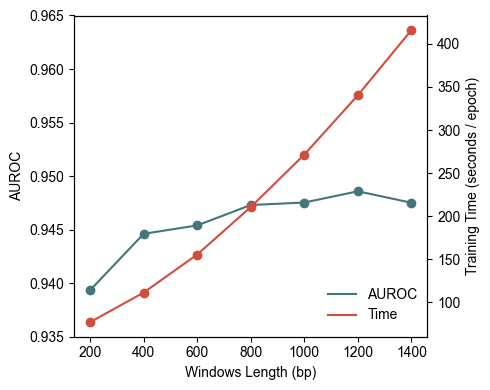

In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

checkpoint = [i*2 for i in range(100, 701, 100)]
aucs = [i[1] for i in test_res[::2]]
ts = [i/31 for i in test_res[1::2]]
ts[0] -= 50

fig = plt.figure(figsize=(5, 4))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(checkpoint, aucs, label='AUROC', color='#44757A')
ax1.scatter(checkpoint, aucs, color='#44757A')
ax2.plot(checkpoint, ts, color='#D44C3C', label='Time')
ax2.scatter(checkpoint, ts, color='#D44C3C')

ax1.set_ylabel('AUROC')
ax2.set_ylabel('Training Time (seconds / epoch)')
ax1.set_xlabel('Windows Length (bp)')
ax1.set_ylim((0.935, 0.965))
fig.legend(bbox_to_anchor=(.87, .3), frameon=False)
plt.tight_layout()
plt.savefig('fig/sfig1.svg')
plt.show()

## Threshold

In [2]:
traindf, testdf = utils.load('data/sramp1/sramp1_mature.data')

In [3]:
testds = df2ds_multi(testdf)
testdl = ds2dl(testds, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 194716/194716 [01:44<00:00, 1867.09it/s]


In [ ]:
import time

# print(f'Building model')
device = "cuda" if torch.cuda.is_available() else "cpu"

utils.setup_seed(42)
model = MultiSRAMP(mode=i).to(device)
model.load_state_dict(torch.load('model/full_400_mature.model'))
loss_fn = TriLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)

print(f'Start to train')
test_res = []
test_res += [test_loop(testdl, model, device, loss_fn)]
    


In [4]:
metric = utils.load('model/full_400_mature.metrics')

In [38]:
print('target\t spec\t thrs')
for i in range(50, 100, 5):
    i /= 100
    spec = (1 - metric[0][3])
    print(f'{i}\t{spec[spec > i][-1]:.4f}\t{metric[0][5][spec > i][-1]:.4f}')


target	 spec	 thrs
0.5	0.5124	0.0001
0.55	0.5667	0.0003
0.6	0.6016	0.0055
0.65	0.6501	0.0286
0.7	0.7005	0.0784
0.75	0.7502	0.1804
0.8	0.8003	0.3577
0.85	0.8504	0.5575
0.9	0.9000	0.7312
0.95	0.9500	0.8735


In [15]:
for idx, i in enumerate(1 - metric[0][3]):
    
    if i > 0.8:
        print(metric[0][5][idx])
    if i > 0.9:
        print(metric[0][5][idx])
        break
    print(i)
    break

inf
1.0


In [11]:
len(metric[0][5])

7463

## Performance

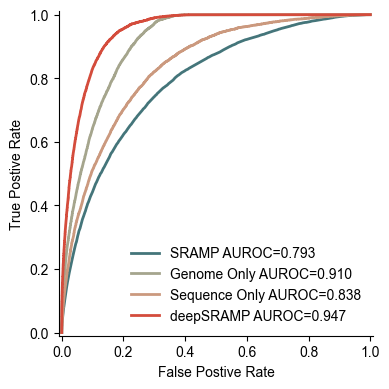

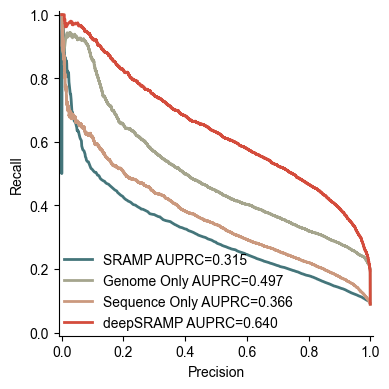

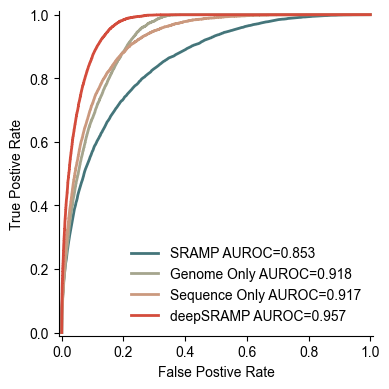

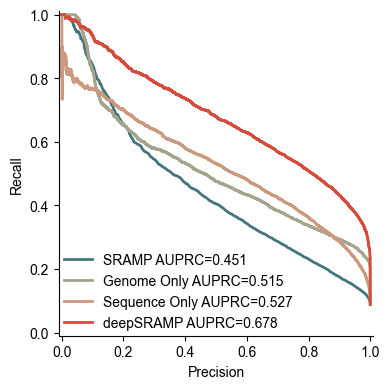

In [5]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

names = ['Genome Only', 'Sequence Only', 'deepSRAMP']


for mode in ['mature', 'full']:
    test_res = []
    for i in ['genomeonly', 'seqonly', 'full']:
        test_res += utils.load(f'model/{i}_400_{mode}.metrics')
    
    data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])
    t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'], index=[i for i in ['genomeonly', 'seqonly', 'full']])
    t.index.name = f'deepSRAMP[{mode}]'
    t.to_csv(f'fig/fig1b_{mode}.csv')

    # sramp1
    if mode == 'mature':
        a = pd.read_csv(f'sramp1_sramp1test.out', sep='\t')
    else:
        a = pd.read_csv(f'sramp1_sramp1test_full.out', sep='\t')
    a = a[a.Position == 51]
    a['y'] = a['Seq_ID'].astype(str).str.split('.', expand=True)[1].astype(int)
    ratio = a.y.sum() / a.shape[0]
    
    # auc
    fig = plt.figure(figsize=(4, 4))
    ax = fig.subplots()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    tpr, fpr, ths = roc_curve(a.y, a['Score(Combined)'])
    t1 = auc(tpr, fpr)
    plt.plot(tpr, fpr, label=f'SRAMP AUROC={t1:.3f}', lw=2, color='#44757A')
    
    colors = ['#A5A58D', '#CB997E', '#D44C3C']
    # colors = ['tab:orange', 'tab:purple', 'tab:red']
    for idx, (name, r) in enumerate(zip(names, test_res)):
        test_loss, aucc, auprcc, fpr, tpr, throc, reca, prec, thprc, mcc, report = r
        plt.plot(fpr, tpr, label=f'{name} AUROC={aucc:.3f}', lw=2, color=colors[idx])
    plt.legend(frameon=False)
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Postive Rate')
    plt.tight_layout()
    plt.savefig(f'fig/fig1b_roc_{mode}.svg', transparent=True)
    plt.show()
    
    # prc
    fig = plt.figure(figsize=(4, 4))
    ax = fig.subplots()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    tpr, fpr, ths = precision_recall_curve(a.y, a['Score(Combined)'])
    t2 = auc(fpr, tpr)
    # plt.plot(fpr, tpr, label=f'SRAMP1 AUC={t2:.3f}', lw=2)
    plt.plot(fpr, tpr, label=f'SRAMP AUPRC={t2:.3f}', lw=2, color='#44757A')
    
    
    for idx, (name, r) in enumerate(zip(names, test_res)):
        test_loss, aucc, auprcc, fpr, tpr, throc, reca, prec, thprc, mcc, report = r
        plt.plot(prec, reca, label=f'{name} AUPRC={auprcc:.3f}', lw=2, color=colors[idx])
    plt.legend(loc=(0,0), frameon=False)
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.tight_layout()
    plt.savefig(f'fig/fig1b_prc_{mode}.svg', transparent=True)
    plt.show()
    # break
    

## Predict

## Ablation

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [7]:
test_res = [utils.load(f'ablation/full_400_{i}.metrics')[0] for i in ['trans', 'gru']] + utils.load(f'model/full_400_mature.metrics')

In [8]:
t = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])
t = pd.DataFrame(t, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'])
method = ['w/o Transformer', 'w/o BiGRU', 'Model']
t['method'] = method
t

,Precision,Recall,F1,Specificity,Accuracy,MCC,AUPRC,AUROC,method
0,0.329769,0.933952,0.487431,0.813594,0.824356,0.490515,0.601566,0.940795,w/o Transformer
1,0.103334,1.000000,0.187312,0.147864,0.224062,0.123610,0.403374,0.894987,w/o BiGRU
2,0.356397,0.929691,0.515267,0.835129,0.843585,0.516051,0.639527,0.947124,Model


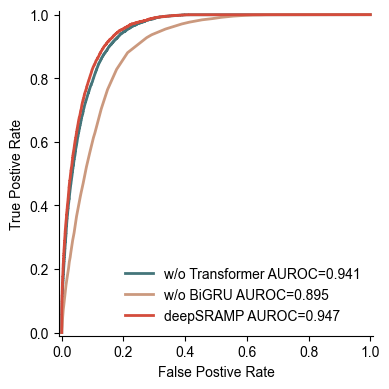

In [13]:
fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

names = ['w/o Transformer', 'w/o BiGRU', 'deepSRAMP']
colors = ['#44757A', '#CB997E', '#D44C3C'] # , '#A5A58D'
for idx, (name, r) in enumerate(zip(names, test_res)):
    test_loss, aucc, auprcc, fpr, tpr, throc, reca, prec, thprc, mcc, report = r
    plt.plot(fpr, tpr, label=f'{name} AUROC={aucc:.3f}', lw=2, color=colors[idx])
plt.legend(frameon=False)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.tight_layout()
plt.savefig(f'fig/sfig3_roc_ablation.svg', transparent=True)
plt.show()

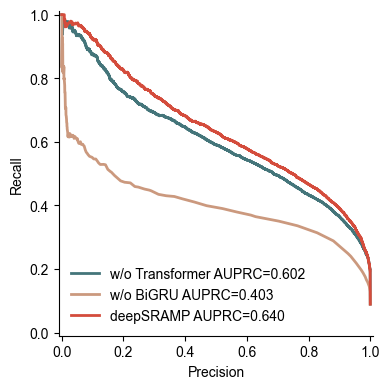

In [14]:
fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

names = ['w/o Transformer', 'w/o BiGRU', 'deepSRAMP']
colors = ['#44757A', '#CB997E', '#D44C3C'] # , '#A5A58D'
for idx, (name, r) in enumerate(zip(names, test_res)):
    test_loss, aucc, auprcc, fpr, tpr, throc, reca, prec, thprc, mcc, report = r
    plt.plot(prec, reca, label=f'{name} AUPRC={auprcc:.3f}', lw=2, color=colors[idx])
plt.legend(frameon=False)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.tight_layout()
plt.savefig(f'fig/sfig3_prc_ablation.svg', transparent=True)
plt.show()

## Misc

In [118]:
test_res = [utils.load(f'ablation/full_400_{i}.metrics')[0] for i in ['trans', 'gru', 'gru2conv']] + utils.load(f'model/full_400_mature.metrics')

In [119]:
t = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])
t = pd.DataFrame(t, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'])
method = ['w/o Transformer', 'w/o GRU', 'GRU -> Conv', 'Model']
t['method'] = method
t

,Precision,Recall,F1,Specificity,Accuracy,MCC,AUPRC,AUROC,method
0,0.329769,0.933952,0.487431,0.813594,0.824356,0.490515,0.601566,0.940795,w/o Transformer
1,0.103334,1.000000,0.187312,0.147864,0.224062,0.123610,0.403374,0.894987,w/o GRU
2,0.103334,1.000000,0.187312,0.147864,0.224062,0.123610,0.173202,0.720784,GRU -> Conv
3,0.356397,0.929691,0.515267,0.835129,0.843585,0.516051,0.639527,0.947124,Model


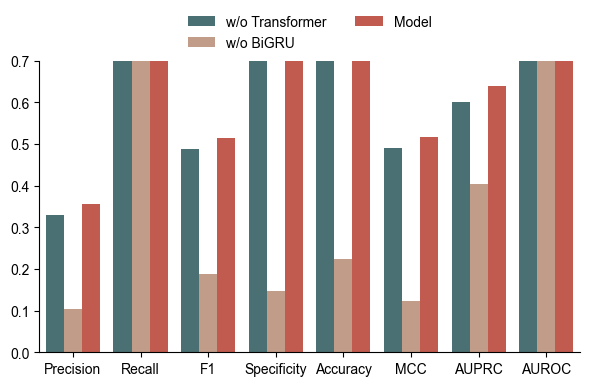

In [125]:
tt = t.set_index(['method']).stack().reset_index()

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.barplot(data=tt, x='level_1', y=0, hue='method', palette=['#44757A', '#CB997E', '#D44C3C']) # , '#A5A58D'
plt.legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.2))
plt.ylim((0, 0.7))
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
# plt.savefig('fig/fig2_allmetric.svg')
plt.show()